In [12]:
import dataclasses
import functools

import jax
from jax import numpy as jnp
import numpy as np

from flax import linen
from flax import struct
import optax
from tensorflow_probability.substrates import jax as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

import gym

import daves_rl_lib
from daves_rl_lib import networks
from daves_rl_lib.environments import environment_lib
from daves_rl_lib.algorithms import deep_q_network
from daves_rl_lib.internal import video_util

from matplotlib import pylab as plt
video_util.initialize_virtual_display()

Display already initialized; doing nothing.


In [19]:
buffer_size = 2048
epsilon = 0.05
discount_factor = 0.98
learning_rate = 0.01
gradient_batch_size = 64
target_weights_decay = 0.99

In [20]:
env = environment_lib.GymEnvironment(
    gym.make("CartPole-v1"), discount_factor=discount_factor)
qvalue_net = networks.make_model([24, 24, env.action_space.num_actions],
                                 obs_size=env.observation_size)
qvalue_optimizer = optax.adam(learning_rate)
learner = deep_q_network.initialize_learner(
    env=env,
    qvalue_net=qvalue_net,
    qvalue_optimizer=qvalue_optimizer,
    buffer_size=buffer_size,
    batch_size=None,
    seed=jax.random.PRNGKey(0))

step_learner = deep_q_network.compile_deep_q_update_step_stateful(
    env=env,
    qvalue_net=qvalue_net,
    qvalue_optimizer=qvalue_optimizer,
    gradient_batch_size=gradient_batch_size,
    target_weights_decay=target_weights_decay,
    epsilon=epsilon)
initial_obs = learner.agent_states.observation

In [21]:
actions = []
durations = []
returns = []
while len(durations) < 200:
    learner = step_learner(learner)
    if learner.agent_states.done:
        print("Episode {} finished after {} steps with return {:.2f}".format(
            len(durations),
            learner.agent_states.num_steps,
            learner.agent_states.episode_return))
        durations.append(learner.agent_states.num_steps)
        returns.append(learner.agent_states.episode_return)


Episode 0 finished after 9 steps with return 8.31
Episode 1 finished after 10 steps with return 9.15
Episode 2 finished after 9 steps with return 8.31
Episode 3 finished after 11 steps with return 9.96
Episode 4 finished after 8 steps with return 7.46
Episode 5 finished after 9 steps with return 8.31
Episode 6 finished after 10 steps with return 9.15
Episode 7 finished after 10 steps with return 9.15
Episode 8 finished after 12 steps with return 10.76
Episode 9 finished after 8 steps with return 7.46
Episode 10 finished after 22 steps with return 17.94
Episode 11 finished after 9 steps with return 8.31
Episode 12 finished after 9 steps with return 8.31
Episode 13 finished after 10 steps with return 9.15
Episode 14 finished after 12 steps with return 10.76
Episode 15 finished after 9 steps with return 8.31
Episode 16 finished after 21 steps with return 17.29
Episode 17 finished after 11 steps with return 9.96
Episode 18 finished after 10 steps with return 9.15
Episode 19 finished after 

Text(0.5, 1.0, 'Episode durations')

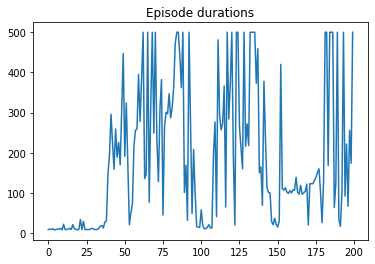

In [22]:
plt.plot(durations)
plt.title('Episode durations')

In [23]:
print("Estimated value", qvalue_net.apply(learner.qvalue_weights, initial_obs))
print("Mean reward", np.mean(
            learner.replay_buffer.valid_transitions().next_state.reward))

Estimated value [60.299805 59.43305 ]
Mean reward 1.0


In [24]:
images = []
# Collect frames to visualize.
for step in range(512):
    learner = step_learner(learner)
    images.append(env._gym_env.render(mode="rgb_array"))

In [25]:
video_util.display_frames(images, frames_per_second=15)